# Download, Save, and Load Macrostrat data

This notebook provides the code for downloading and locally saving Macrostrat data using their API, as well as subsequently loading it quickly for local processing/analysis.

In [ ]:
import requests
import json
import io
import geopandas as gpd
import matplotlib.pyplot as plt
from helper import *

## download data

The following code blocks download the necessary Macrostrat column and unit data to generate geojson files columns.json, units.json, and units_seds.json. These data are also then saved as shapefiles, since these load much more quickly than the json files.

In [2]:
api_url_base = 'https://macrostrat.org/api/'

### download columns

In [3]:
# get all units as geojson
response = requests.get(api_url_base + 'columns?all&format=geojson_bare&response=long')
columns = gpd.read_file(io.StringIO(response.content.decode('utf-8')))
columns.set_index('col_id', inplace=True)
columns.to_file('data/columns_2023-06.gpkg', driver='GPKG')

### download all units

In addition to downloading all units hosted by Macrostrat, we'll also consider extract units that are only sedimentary.

Note that the geojson output format, for whatever reason, does not include the "environ" column that is included with the csv output. For this reason, it is necessary to additionally download the csv version of the units data so that we can add it to the units dataframe for later parsing of the environmental descriptors for each unit.

In [5]:
# get all units as geojson
response = requests.get(api_url_base + 'units?all&format=geojson_bare&response=long')
units_geo = gpd.read_file(io.StringIO(response.content.decode('utf-8')))
units_geo.set_index('unit_id', inplace=True)

# get all units as csv
response = requests.get(api_url_base + 'units?all&format=csv&response=long')
units = pd.read_csv(io.StringIO(response.content.decode('utf-8')), index_col=0)

# merge
units = units_geo.merge(units['environ'], on='unit_id')

# save to shapefile (much faster to deal with)
units.to_file('data/units_2023-06.gpkg', driver='GPKG')

### download sedimentary units

Let's do the same for the sedimentary units exclusively, but we'll need to do some processing of the environmental information.

#### process environmental tagging

Recall that the environmental tagging in the units API is complicated. Rather than simply put the environment ID in the 'environ' tag, the authors opted to concatenate the environmental names, types, and classes, separated by '|', for each unit in the database.

Put another way, the environmental tagging reference page [here](https://macrostrat.org/api/defs/environments?all) shows that there are 93 unique environments, each with their own ID. However, what is labeled in the description for each unit is a string like this: 

> lacustrine indet. lacustrine non-marine |fluvial indet. fluvial non-marine

which is not the environmental ID, but instead the concatenation of the three hierarchical text descriptors for each environment (name, type, class). 

All this to say that finding the appropriate environment ID with `env_id()` requires knowing the effective key string, which I construct below as the concatenation described above, and save as [`data/environments.csv`](data/environments.csv).

In [6]:
#  get list of unique environments and make keys
response = requests.get(api_url_base + 'defs/environments?all&format=csv')
env = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
env['type'].replace(np.nan, '', inplace=True)
env['key'] = env['name'] + ' ' + env['type'] + ' ' + env['class']
env.to_csv('data/environments_2023-06.csv', index=False)

In [7]:
# get all units as geojson
response = requests.get(api_url_base + 'units?lith_class=sedimentary&format=geojson_bare&response=long')
units_geo = gpd.read_file(io.StringIO(response.content.decode('utf-8')))
units_geo.set_index('unit_id', inplace=True)

# get all units as csv
response = requests.get(api_url_base + 'units?lith_class=sedimentary&format=csv&response=long')
units = pd.read_csv(io.StringIO(response.content.decode('utf-8')), index_col=0)

# merge
units = units_geo.merge(units['environ'], on='unit_id')

# save to shapefile (much faster to deal with)
units.to_file('data/units_seds_2023-06.gpkg', driver='GPKG')

## load data

Having downloaded the data, the following code blocks load in the geojson files into geodataframes and isolate the North American (project id = 1) columns and units. I also project the coordinates into a Lambert Conformal Conic projection centered on Michigan for better visualization. See [helper.py](helper.py) for the corresponding functions.

In [8]:
columns = load_shapefile('data/columns_2023-06.gpkg', 'col_id', project_id=1)
units = load_shapefile('data/units_2023-06.gpkg', 'unit_id', project_id=1)
units_seds = load_shapefile('data/units_seds_2023-06.gpkg', 'unit_id', project_id=1)

## sanity check plot

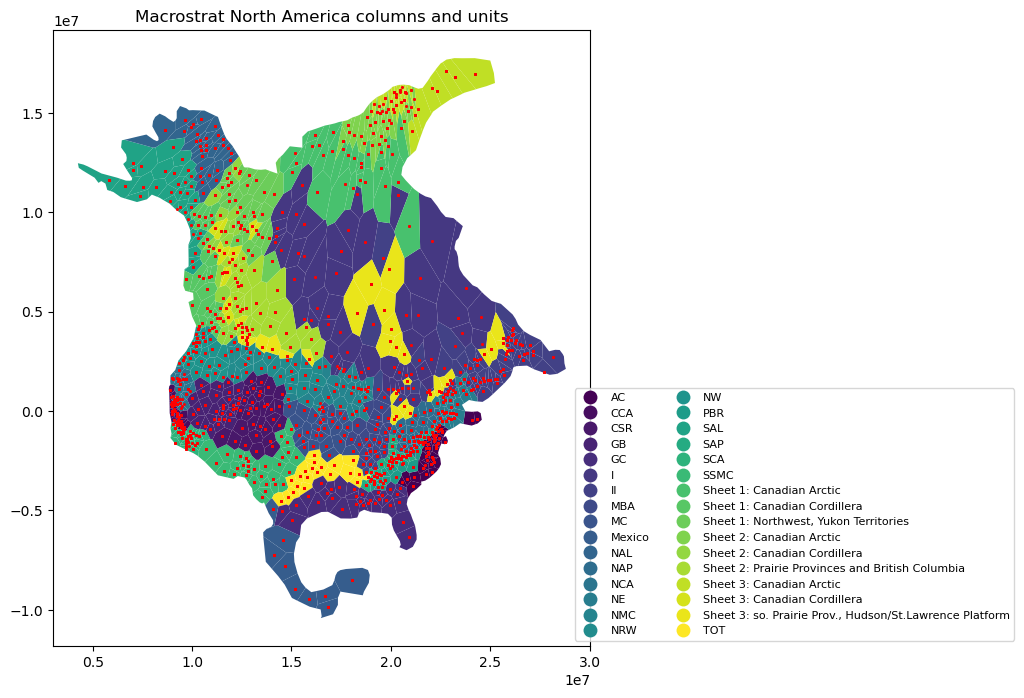

In [12]:
# set up figure 
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
columns.plot(ax=ax, column='col_group', figsize=(10,10), cmap='viridis', legend=True, 
                legend_kwds={'loc': 'lower right', 
                             'ncol': 2, 
                             'bbox_to_anchor': (1.8, 0), 
                             'fontsize': 8})
units.plot(ax=ax, marker='.', markersize=2, color='r')
plt.title('Macrostrat North America columns and units')
plt.show()